В цьому домашньому завданні ми проведемо додаткові експерименти для рішення задачі бінарної класифікації і створимо ваш новий submission на змагання на Kaggle.

-----------


**Завдання 0**. Завантажте дані `train.csv`, `test.csv`, `sample_submission.csv` зі змагання на Kaggle ["Bank Customer Churn Prediction (DLU Course)"](https://www.kaggle.com/t/7c080c5d8ec64364a93cf4e8f880b6a0). Для завантаження потрібно долучитись до змагання (натиснути кнопку "Join").

**Завдання 1**. **Збираємо весь код з попереднього ДЗ в одному місці.** В лекційному ноутбуці `Логістична регресія з ScikitLearn. Повна ML задача.ipynb` ми познайомились з поняттям пайплайнів, а також я показала, як компактно виглядає рішення МЛ задачі, якщо ми зберемо весь код разом.

Оскільки ми далі будемо робити експерименти, які включають ті самі етапи попередньої обробки, але інше моделювання - буде зручно мати весь код компактно і під рукою. Тому зараз ми займемось збором коду до купи :) Після цього завдання для подальших експериментів ви можете перенести частини розвʼязку взагалі в окремий `.py` файл, аби було зручно імпортувати функції.

Зі свого рішення в попередньому домашньому завданні (`Логістична регресія з scikit learn.ipynb`) зберіть усі кроки розвʼязку задачі разом з використанням `sklearn.Pipeline` за прикладом з лекції.

Ваш код нижче має містити
1. Читання даних з файлу (поза пайплайном).
2. Розбиття на тренувальний і валідаційний набори, де валідаційний містить 20% даних (поза пайплайном).
3. Виділення категоріальних і числових колонок (поза пайплайном).
4. Підготовку категоріальних і числових колонок (частина пайплайну). В прикладі в лекції ми оформлювали обробку числових і категоріальних колонок в окремі трансформери `numeric_transformer`, `categorical_cols`. Рекоемндую зробити саме так, так потім зручніше вносити зміни :)
5. Тренування лог регресії (частина пайплайну).
6. Запуск пайплайну на тренування на трен. даних (поза пайплайном).
7. Запуск пайплайну на передбачення на трен і вал. даних і вимір метрик якості ROC-AUC + вивдення Confusion Matrix (поза пайплайном).
8. Збереження моделі в формат joblib (поза пайплайном).

Ви це все вже зробили в попереднтьому ДЗ! Тож, тут просто заадча все зібрати разом.

Нижче я додала підказки, що покроково ви маєте зробити. Якщо ви почуваєтесь впевнено, можете видалити ці підказки і реалізувати все самостійно, або ж - просто заповнити пропуски.

Завдання оцінюється в 10 балів. Головний результат - аби код в фіналі був робочий. Бо за не робочий нам гроші ніхто не заплатить :)

In [123]:
!pip install opendatasets --upgrade --quiet

In [124]:
import opendatasets as od
import os
import pandas as pd
import numpy as np
from sklearn.preprocessing import MinMaxScaler, OneHotEncoder, PolynomialFeatures
from sklearn.compose import ColumnTransformer
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression, LinearRegression, Ridge, Lasso, ElasticNet
from sklearn.metrics import accuracy_score, confusion_matrix, f1_score, roc_curve, auc, mean_squared_error
from sklearn.pipeline import Pipeline
import joblib
import matplotlib.pyplot as plt
import seaborn as sns

In [125]:
dataset_url = 'https://www.kaggle.com/competitions/bank-customer-churn-prediction-dlu/data?select=train.csv'
od.download(dataset_url)

Skipping, found downloaded files in "./bank-customer-churn-prediction-dlu" (use force=True to force download)


In [126]:
data_dir = './bank-customer-churn-prediction-dlu'
train_csv = data_dir + '/train.csv'
test_csv =  data_dir + '/test.csv'
sample_submission_csv =  data_dir + '/sample_submission.csv'

Area under ROC score on Train dataset: 0.882389%


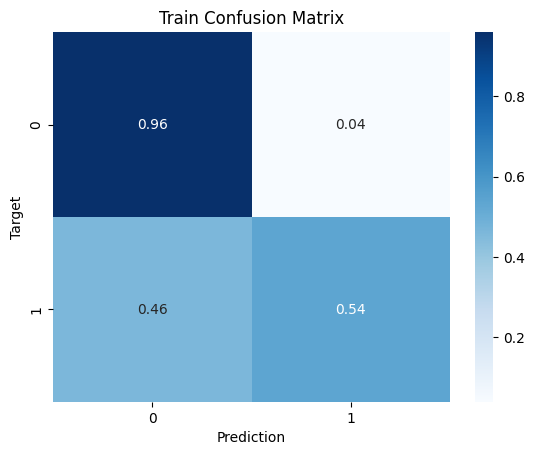

Area under ROC score on Validation dataset: 0.879671%


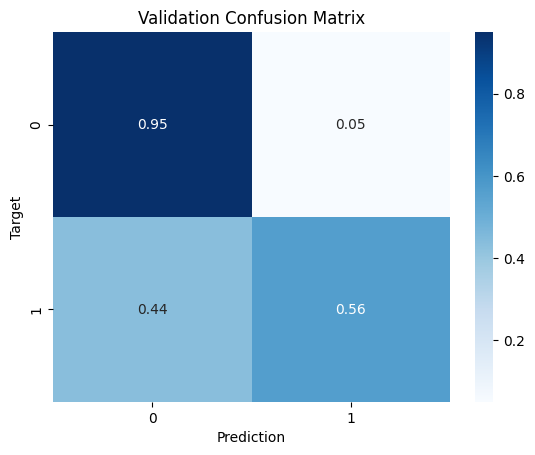

['churn_prediction_log_reg.joblib']

In [127]:
df = pd.read_csv(train_csv, index_col=0)

# create train and validation datasets
train_df, val_df = train_test_split(df, test_size=0.2, random_state=42, stratify = df.Exited)

# define inputs and targets
input_cols = list(train_df.columns)[0:-1]
target_col =  'Exited'
train_inputs, train_targets = train_df[input_cols].copy(), train_df[target_col].copy()
val_inputs, val_targets = val_df[input_cols].copy(), val_df[target_col].copy()

# select numerical and categorical columns
numeric_cols = train_inputs.select_dtypes(include=np.number).columns.tolist()
numeric_cols = list(filter(lambda x: x not in ('id', 'CustomerId'), numeric_cols))
categorical_cols = train_inputs.select_dtypes(['object']).columns.tolist()
categorical_cols.remove('Surname')

# create transformers
numeric_transformer = Pipeline(steps=[
    ('scaler', MinMaxScaler())
])
categorical_transformer = Pipeline(steps=[
    ('onehot', OneHotEncoder(sparse_output=False, handle_unknown='ignore'))
])

# combine transformers into a preprocessor
preprocessor = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, numeric_cols),
        ('cat', categorical_transformer, categorical_cols)
    ])

# create a pipeline with preprocessor and a classifier
model_pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('classifier', LogisticRegression(solver='liblinear'))
])

# train the pipeline
model_pipeline.fit(train_inputs, train_targets)

# function for predicting and calculating the metrics
def predict_and_plot(model_pipeline, inputs, targets, name=''):
    # make predictions
    pred_proba = model_pipeline.predict_proba(inputs)[:, 1]
    preds =  model_pipeline.predict(inputs)
    # compute ROC curve
    fpr, tpr, thresholds = roc_curve(targets, pred_proba, pos_label=1)
    # compute AUROC
    roc_auc = auc(fpr, tpr)
    print(f"Area under ROC score on {name} dataset: {roc_auc:.6f}%")
    # compute confusion matrix
    confusion_matrix_ = confusion_matrix(targets, preds, normalize='true')
    plt.figure()
    ax = sns.heatmap(confusion_matrix_, annot=True, cmap='Blues')
    plt.xlabel('Prediction')
    plt.ylabel('Target')
    plt.title('{} Confusion Matrix'.format(name))
    plt.show()
    return preds

# predict and calculate the metrics for train and validation sets
train_preds = predict_and_plot(model_pipeline, train_inputs, train_targets, name='Train')
val_preds = predict_and_plot(model_pipeline, val_inputs, val_targets, name='Validation')

# save the model
joblib.dump(model_pipeline, 'churn_prediction_log_reg.joblib')

**Завдання 2**. Такс, у нас з вами є вже готовий пайплайн. Давайте проведемо нові експерименти.

  Додайте в попередню обробку числових колонок генерацію polinomal features до степені 2 включно. Для цього створіть новий препроцесор і створіть новий пайплайн.

  Запустіть пайплайн на тренування і виведіть метрики для тренувального і валідаційного набору. Напишіть, як вам модель? Чи спостерігається в цій моделі overfit чи underfit? Чи ця модель добре генералізує?

In [128]:
# create a transformer with polynomial features with degree 2
numeric_transformer_poly2 = Pipeline(steps=[
    ('scaler', MinMaxScaler()),
    ('polynomial_features', PolynomialFeatures(degree=2))
])

# create a new preprocessor
preprocessor_poly2 = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer_poly2, numeric_cols),
        ('cat', categorical_transformer, categorical_cols)
    ])

# create a pipeline with preprocessor and a classifier
model_pipeline_poly2 = Pipeline(steps=[
    ('preprocessor', preprocessor_poly2),
    ('classifier', LogisticRegression(solver='liblinear'))
])

# train the pipeline
model_pipeline_poly2.fit(train_inputs, train_targets)

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('num',
                                                  Pipeline(steps=[('scaler',
                                                                   MinMaxScaler()),
                                                                  ('polynomial_features',
                                                                   PolynomialFeatures())]),
                                                  ['CreditScore', 'Age',
                                                   'Tenure', 'Balance',
                                                   'NumOfProducts', 'HasCrCard',
                                                   'IsActiveMember',
                                                   'EstimatedSalary']),
                                                 ('cat',
                                                  Pipeline(steps=[('onehot',
                                                                   OneHotEncoder(handle_unknown='ignore',
                                                                                 sparse_output=False))]),
                                                  ['Geography', 'Gender'])])),
                ('classifier', LogisticRegression(solver='liblinear'))])

Area under ROC score on Train dataset: 0.921732%


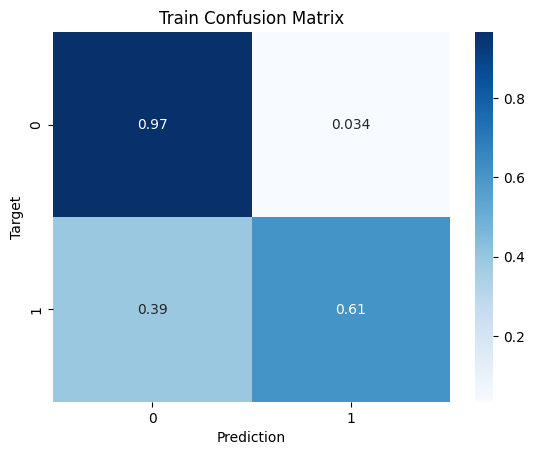

Area under ROC score on Validation dataset: 0.919059%


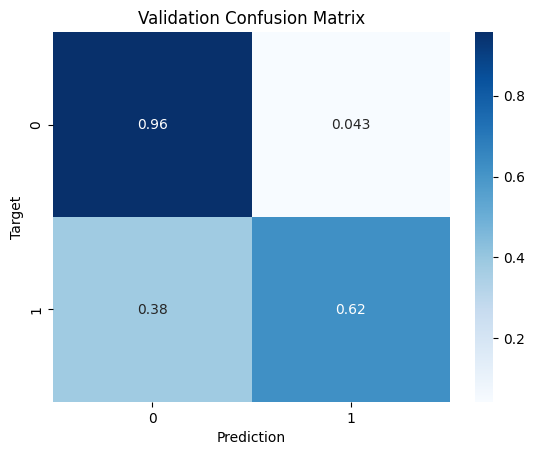

In [131]:
train_preds_poly2 = predict_and_plot(model_pipeline_poly2, train_inputs, train_targets, name='Train')
val_preds_poly2 = predict_and_plot(model_pipeline_poly2, val_inputs, val_targets, name='Validation')

Метрики для train i validation датасетів дуже подібні, тобто модель добре перформить на даних, які вона ніколи не бачила, отже можемо сказати, що модель добре генералізує. Ні overfit ні underfit не спостерігається.

**Завдання 3**. Тепер давайте створимо ще новий пайплайн, тільки тепер поліноміальні ознаки згенеруємо до степені 4. Зробіть висновок про якість моделі. Якщо вам подобається резульат якоїсь з моделей в цьому ДЗ - рекомендую зробити submission в змаганні.

In [130]:
# create a transformer with polynomial features with degree 4
numeric_transformer_poly4 = Pipeline(steps=[
    ('scaler', MinMaxScaler()),
    ('polynomial_features', PolynomialFeatures(degree=4))
])

# create a new preprocessor
preprocessor_poly4 = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer_poly4, numeric_cols),
        ('cat', categorical_transformer, categorical_cols)
    ])

# create a pipeline with preprocessor and a classifier
model_pipeline_poly4 = Pipeline(steps=[
    ('preprocessor', preprocessor_poly4),
    ('classifier', LogisticRegression(solver='liblinear'))
])

# train the pipeline
model_pipeline_poly4.fit(train_inputs, train_targets)

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('num',
                                                  Pipeline(steps=[('scaler',
                                                                   MinMaxScaler()),
                                                                  ('polynomial_features',
                                                                   PolynomialFeatures(degree=4))]),
                                                  ['CreditScore', 'Age',
                                                   'Tenure', 'Balance',
                                                   'NumOfProducts', 'HasCrCard',
                                                   'IsActiveMember',
                                                   'EstimatedSalary']),
                                                 ('cat',
                                                  Pipeline(steps=[('onehot',
                                                                   OneHotEncoder(handle_unknown='ignore',
                                                                                 sparse_output=False))]),
                                                  ['Geography', 'Gender'])])),
                ('classifier', LogisticRegression(solver='liblinear'))])

Area under ROC score on Train dataset: 0.933059%


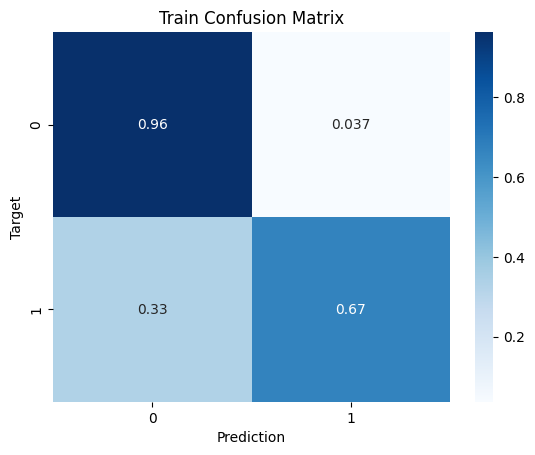

Area under ROC score on Validation dataset: 0.930083%


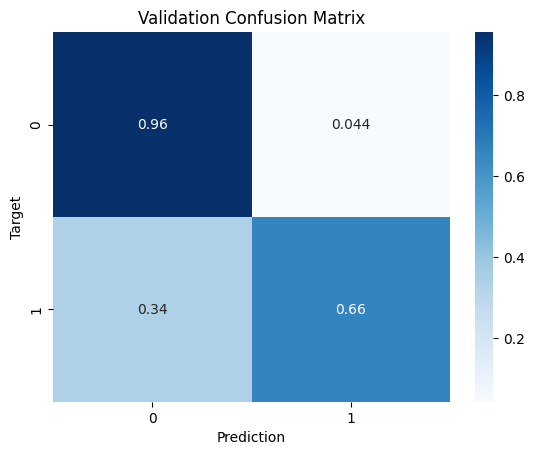

In [132]:
train_preds_poly4 = predict_and_plot(model_pipeline_poly4, train_inputs, train_targets, name='Train')
val_preds_poly4 = predict_and_plot(model_pipeline_poly4, val_inputs, val_targets, name='Validation')

Ця модель перформить ще трошки краще. Вона теж добре генералізує, ні overfit ні underfit не спостерігається.

**Завдання 4. Перенавчання і регуляризація**.

  Скачайте набір даних `regression_data.csv`. Звичайте набір даних з `regression_data.csv`, розбийте на train і test (в тест 20%) і натренуйте модель лінійної регресії з масштабуванням числових ознак і поліноміальними ознаками до степені **5 включно**.

  Виміряйте якість прогностичної моделі і зробіть висновок, чи модель хороша, чи вона добре генералізує?


In [133]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [134]:
df2 = pd.read_csv("/content/drive/MyDrive/Machine Learning/Data/regression_data.csv")
df2.head()

,feature_1,feature_2,feature_3,feature_4,feature_5,target
0,-0.190339,-1.382800,-0.875618,0.538910,-1.037246,28.938854
1,-0.321386,-0.563725,0.412931,-0.147057,-0.825497,-7.664581
2,2.122156,-1.519370,1.032465,-1.260884,0.917862,-63.845482
3,-1.380101,-0.055548,-1.703382,0.074095,1.628616,4.076259
4,-0.072829,-1.514847,-0.846794,0.714000,0.473238,34.879013


Перевіримо датасет на відсутність значень і типи даних

In [135]:
df2.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 129 entries, 0 to 128
Data columns (total 6 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   feature_1  129 non-null    float64
 1   feature_2  129 non-null    float64
 2   feature_3  129 non-null    float64
 3   feature_4  129 non-null    float64
 4   feature_5  129 non-null    float64
 5   target     129 non-null    float64
dtypes: float64(6)
memory usage: 6.2 KB


In [201]:
# create train and validation datasets
train_df2, val_df2 = train_test_split(df2, test_size=0.2, random_state=42)

# define inputs and targets
input_cols2= list(train_df2.columns)[0:-1]
target_col2 = 'target'
train_inputs2, train_targets2 = train_df2[input_cols2].copy(), train_df2[target_col2].copy()
val_inputs2, val_targets2 = val_df2[input_cols2].copy(), val_df2[target_col2].copy()

# create a transformer with polynomial features with degree 5
numeric_transformer_poly5 = Pipeline(steps=[
    ('scaler', MinMaxScaler()),
    ('polynomial_features', PolynomialFeatures(degree=5))
])

# create a pipeline with preprocessor and a classifier
model_pipeline_poly5 = Pipeline(steps=[
    ('preprocessor', numeric_transformer_poly5),
    ('classifier', LinearRegression())
])

# train the pipeline
model_pipeline_poly5.fit(train_inputs2, train_targets2)

Pipeline(steps=[('preprocessor',
                 Pipeline(steps=[('scaler', MinMaxScaler()),
                                 ('polynomial_features',
                                  PolynomialFeatures(degree=5))])),
                ('classifier', LinearRegression())])

In [202]:
def evaluate_model(model, X_train, y_train, X_val, y_val):
    y_train_pred = model.predict(X_train)
    y_val_pred = model.predict(X_val)
    loss_train = mean_squared_error(y_train, y_train_pred, squared=False)
    loss_val = mean_squared_error(y_val, y_val_pred, squared=False)

    return loss_train, loss_val

In [203]:
evaluate_model(model_pipeline_poly5, train_inputs2, train_targets2, val_inputs2, val_targets2)

(4.3136210552758546e-13, 16.156053353383708)

Перевіримо середнє і стандартне відхилення таргета на валідаційному датасеті:

In [204]:
val_targets2.mean(), val_targets2.std()

(6.190106769386836, 49.258381226353556)

Перевіримо, як перформить звичайна лінійна регресія без використання поліноміальних ознак:

In [206]:
evaluate_model(LinearRegression().fit(train_inputs2, train_targets2), train_inputs2, train_targets2, val_inputs2, val_targets2)

(1.0664716922463595, 0.8833273761660392)

Ця модель погано генералізує і погано перформить на нових даних. Loss для train сету наближається до нуля, тоді як для validation сету він доволі великий. Ця модель є явно overfit.

**Завдання 5**. Натренуйте моделі Lasso(), Ridge(), ElasaticNet() на цих даних (з поліном ознаками до степені 20 включно), порівняйте якість з тою, яка була отримана з лог регресією. Яка модель найкраще генералізує і чому на ваш погляд (можливо треба буде для відповіді зробити додатковий аналіз ознак)?

In [231]:
# create models
lr = LinearRegression()
ridge = Ridge(max_iter=100)
lasso = Lasso(alpha=1e-4)
elastic_net = ElasticNet(alpha=1e-4)

models = [lr, ridge, lasso, elastic_net]

# add polynomial features up to 20 degree
poly_features = PolynomialFeatures(degree=20)
train_inputs2_poly20 = poly_features.fit_transform(train_inputs2)
val_inputs2_poly20 = poly_features.transform(val_inputs2)

In [232]:
for model in models:
    model.fit(train_inputs2_poly20, train_targets2)
    eval_results  = evaluate_model(model, train_inputs2_poly20, train_targets2, val_inputs2_poly20, val_targets2)
    print(f'{str(model)}: {eval_results}\n')

LinearRegression(): (0.004971543605935018, 102877.9022577895)



/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_ridge.py:255: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn(


Ridge(max_iter=100): (32.58183735565118, 9048.133334238606)

Lasso(alpha=0.0001): (0.2665830461321641, 7.179860802557518)

ElasticNet(alpha=0.0001): (0.25475002147002507, 7.665727785564323)



Найкраще спрацювали моделі Lasso і ElasticNet знизивши loss на валідаційному датасеті в тисячі разів в порівнянні з LinearRegression, однак ці моделі все ще перформлять гірше аніж перформила би модель без використання поліноміальних ознак (іі loss - 0.88). Можемо зробити висновок, що регуляризація не допоможе нам досятгти оптимальних результатів при використанні поліномів такого висого ступеня.